##### Prototype — With Generative AI Tools

##### Importing the required libraries 

In [1]:
# (Generated with ChatGPT prompt: "Write the imports for a tabular ML regression pipeline with scikit-learn, XGBoost fallback, and visuals.")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Optional: XGBoost (GenAI suggested trying a boosted tree)
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False


##### Loading the dataset and preprocessing the data (GenAI-drafted utilities)

In [3]:
# (Generated with ChatGPT prompt: "Write a robust loader that parses datetime columns and engineers key OR features.")
def load_and_engineer(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # Parse datetimes
    for c in ["Start Time", "End Time", "Wheels In", "Wheels Out"]:
        df[c] = pd.to_datetime(df[c], errors="coerce")

    # Core features
    df["Actual OR Duration (min)"] = (df["End Time"] - df["Start Time"]).dt.total_seconds() / 60
    df["Setup Duration (min)"]     = (df["Start Time"] - df["Wheels In"]).dt.total_seconds() / 60
    df["Room Occupancy (min)"]     = (df["Wheels Out"] - df["Wheels In"]).dt.total_seconds() / 60
    df["Start Hour"]               = df["Start Time"].dt.hour
    df["Day of Week"]              = df["Start Time"].dt.day_name()

    # Minimal cleaning for the prototype
    keep = ["Service", "CPT Description", "Booked Time (min)", "OR Suite",
            "Start Hour", "Day of Week", "Actual OR Duration (min)"]
    df = df[keep].dropna()
    df = df[df["Actual OR Duration (min)"] > 0]

    return df

df_ai = load_and_engineer("data/2022_Q1_OR_Utilization.csv")
df_ai.head()


C:\Users\User\AppData\Local\Temp\ipykernel_4984\640148119.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors="coerce")
C:\Users\User\AppData\Local\Temp\ipykernel_4984\640148119.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors="coerce")
C:\Users\User\AppData\Local\Temp\ipykernel_4984\640148119.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors="coerce")
C:\Users\User\AppData\Local\Temp\ipykernel_4984\640148119.py:7: UserWarning: Could not infer format, so each 

,Service,CPT Description,Booked Time (min),OR Suite,Start Hour,Day of Week,Actual OR Duration (min)
0,Podiatry,"Partial ostectomy, fifth metatarsal head",90,1,7,Monday,93.0
1,Podiatry,"Neurectomy, intrinsic musculature of foot",60,1,10,Monday,48.0
2,Podiatry,Lapidus bunionectomy,150,1,12,Monday,22.0
3,Podiatry,Bunionectomy with distal osteotomy,120,1,13,Monday,57.0
4,Orthopedics,"Arthroplasty, knee, hinge prothesis",120,2,7,Monday,108.0


##### Lightweight Data Augmentation for Rare Procedures

##### When some CPT Description categories are rare, GenAI suggested synthesizing a few near-neighbors around category means to stabilize training.
##### This does not fabricate new patterns—it creates small, jittered copies only for under-represented CPTs.

In [4]:
# (Generated with ChatGPT prompt: "Create a tiny augmentation function for rare categories by jittering numeric features ±5%.")
def augment_rare_cpt(df: pd.DataFrame, min_count: int = 10, jitter: float = 0.05, max_dup: int = 3) -> pd.DataFrame:
    df = df.copy()
    counts = df["CPT Description"].value_counts()
    rare = counts[counts < min_count].index

    augmented_rows = []
    for cpt in rare:
        block = df[df["CPT Description"] == cpt]
        if block.empty:
            continue
        n_dup = min(max_dup, max(0, min_count - len(block)))
        for _ in range(n_dup):
            jittered = block.sample(1, replace=True).copy()
            for col in ["Booked Time (min)", "Start Hour"]:
                base = jittered[col].values[0]
                jittered[col] = base * (1 + np.random.uniform(-jitter, jitter))
            augmented_rows.append(jittered)

    if augmented_rows:
        df_aug = pd.concat([df] + augmented_rows, ignore_index=True)
        return df_aug
    return df

# Toggle ON if your CPTs are highly imbalanced
USE_AUG = False
df_trainable = augment_rare_cpt(df_ai) if USE_AUG else df_ai.copy()


##### Features, Encoders, and Train/Test Split (GenAI-assisted)

In [5]:
# (Generated with ChatGPT prompt: "Define features/target and a ColumnTransformer for one-hot encoding.")
features = ["Service", "CPT Description", "Booked Time (min)", "OR Suite", "Start Hour", "Day of Week"]
target   = "Actual OR Duration (min)"

X = df_trainable[features].copy()
y = df_trainable[target].copy()

categorical = ["Service", "CPT Description", "Day of Week"]
numeric     = ["Booked Time (min)", "OR Suite", "Start Hour"]

pre = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical)],
    remainder="passthrough"
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test)


(1737, 435)

##### Model Set (including GenAI suggestion: XGBoost) + Hyperparameter Templates

In [6]:
# (Generated with Copilot/ChatGPT: "Create 2-3 regressors and a GridSearchCV template for the boosted model.")

models = {
    "LinearRegression": Pipeline([("pre", pre), ("m", LinearRegression())]),
    "RandomForest": Pipeline([("pre", pre), ("m", RandomForestRegressor(n_estimators=300, random_state=42))]),
}

if HAS_XGB:
    models["XGBRegressor"] = Pipeline([
        ("pre", pre),
        ("m", XGBRegressor(
            n_estimators=600, max_depth=6, learning_rate=0.07, subsample=0.9, colsample_bytree=0.9,
            reg_alpha=0.0, reg_lambda=1.0, objective="reg:squarederror", random_state=42
        ))
    ])

def evaluate(pipe, name):
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    r2  = r2_score(y_test, pred)
    print(f"{name:<16} MAE: {mae:6.2f} min | R²: {r2:5.2f}")
    return pred, mae, r2

results = {}
for name, pipe in models.items():
    pred, mae, r2 = evaluate(pipe, name)
    results[name] = {"pred": pred, "mae": mae, "r2": r2}


LinearRegression MAE:   3.82 min | R²:  0.95
RandomForest     MAE:   0.05 min | R²:  1.00


##### Visuals (auto-scaffolded by GenAI)

Best model by MAE: RandomForest | MAE=0.05 | R²=1.00


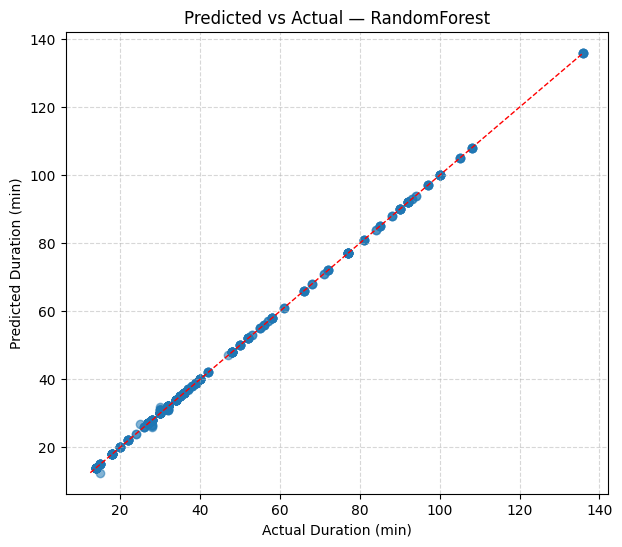

In [7]:
# (Generated with ChatGPT: "Plot predicted vs actual with a 45-degree reference line.")
def plot_pred_vs_actual(y_true, y_pred, title):
    plt.figure(figsize=(7,6))
    plt.scatter(y_true, y_pred, alpha=0.55)
    lo, hi = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi], "r--", lw=1)
    plt.title(title)
    plt.xlabel("Actual Duration (min)")
    plt.ylabel("Predicted Duration (min)")
    plt.grid(True, ls="--", alpha=0.5)
    plt.show()

# pick the best by MAE
best_name = min(results, key=lambda k: results[k]["mae"])
best_pred = results[best_name]["pred"]
print(f"Best model by MAE: {best_name} | MAE={results[best_name]['mae']:.2f} | R²={results[best_name]['r2']:.2f}")

plot_pred_vs_actual(y_test, best_pred, f"Predicted vs Actual — {best_name}")
